# Kobe Bryant Shot Prediction


## Importing data & libs


In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split , cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,log_loss
from sklearn.model_selection import GridSearchCV
import optuna


In [6]:
kobe_data=pd.read_csv('/content/drive/MyDrive/italo/kobe_bryant_shot_prediction/data.csv')
kobe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [7]:
kobe_data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [8]:
data = kobe_data.dropna().copy()
data['game_date']=pd.to_datetime(data['game_date'])
data['year']=data['game_date'].dt.year
data['missed']=data['shot_made_flag'].apply(lambda x: 1 if x==0 else 0)
data['converted']=data['shot_made_flag'].apply(lambda x: 1 if x==1 else 0)



In [9]:
kobe_data

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
30693,Tip Shot,Tip Shot,398,49900088,34.0443,0,0,-118.2698,6,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30694
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


##EDA


### Shots per Year & Accuracy per Year

In [10]:

accuracy_data=data[['year','converted','missed']]
accuracy_data=accuracy_data.groupby('year').sum(['converted','missed']).reset_index()
accuracy_data['accuracy']=accuracy_data['converted']/(accuracy_data['converted']+accuracy_data['missed'])
accuracy_data.sort_values('converted',ascending=False).head()


,year,converted,missed,accuracy
13,2009,924,1049,0.468322
12,2008,858,941,0.476932
10,2006,825,938,0.467952
6,2002,822,1038,0.441935
16,2012,815,1051,0.436763


In [11]:

fig = make_subplots(rows=2, cols=1, subplot_titles=('Shots per year', 'Accuracy per year'),shared_xaxes=True)

fig.add_trace(
    go.Bar(x=accuracy_data['year'], y=accuracy_data['converted'], name='Successful shots'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=accuracy_data['year'], y=accuracy_data['missed'], name='Missed'),
              row=1, col=1
)

fig.add_trace(
    go.Scatter(x=accuracy_data['year'], y=accuracy_data['accuracy'], name='Accuracy',
               text=accuracy_data['accuracy'],textposition='top center'),
    row=2, col=1
)

average_accuracy = accuracy_data['converted'].sum()/(accuracy_data['converted'].sum()+accuracy_data['missed'].sum())
fig.add_trace(
    go.Scatter(x=accuracy_data['year'],y=[average_accuracy]* len(accuracy_data),
               name='Average accuracy',line=dict(dash='dash')),
    row=2, col=1
)

fig.update_layout(height=600, showlegend=True)
fig.update_traces(selector=dict(name='Accuracy'), row=2, col=1)
fig.update_traces(selector=dict(name='Converted'), row=1, col=1)
fig.update_traces(selector=dict(name='Missed'), row=1, col=1)

fig.show()


Kobe Bryant won the NBA championship in the years 2000, 2001, 2002, 2009, and 2010. It is noticeable that Kobe's accuracy in those years was equal to or higher than his average.

It's worth noting that in the years 2008 and 2006, Kobe was the runner-up, and those were years with high accuracy. It's clear that Kobe was a key player in the title contention during those seasons.


### Relationship between successful shots and court position


In [12]:
sucess_shot=data.query('shot_made_flag == 1').copy()
sucess_shot['opacity']=1
sucess_shot.loc[sucess_shot['combined_shot_type']== 'Jump Shot','opacity']=0.8



<ipython-input-12-37289ac5fa3e>:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [13]:
fig1=px.scatter(sucess_shot,x='loc_x',y='loc_y',color='combined_shot_type',opacity=sucess_shot['opacity'],
               title='Successful Shots Scatter Plot - Shot Types')
fig2 = px.histogram(sucess_shot, x='combined_shot_type')

fig = make_subplots(rows=1, cols=2, subplot_titles=('Shot Zone Area', 'Combined Shot Type'))

for trace in fig1.data:
    fig.add_trace(trace, row=1, col=2)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=1)

fig.show()

In [14]:
fig1=px.scatter(sucess_shot,x='loc_x',y='loc_y',color='shot_zone_area',
               title='Successful Shots Scatter Plot - Shot Types')

fig2=px.histogram(sucess_shot,x='shot_zone_area')

fig=make_subplots(rows=1,cols=2,subplot_titles=('Sucessfull shots scater plot', 'zone area'))

for trace in fig1.data:
  fig.add_trace(trace,row=1,col=2)

for trace in fig2.data:
  fig.add_trace(trace,row=1,col=1)

fig.show()


In [15]:
fig1=px.scatter(sucess_shot,x='loc_x',y='loc_y',color='shot_zone_range')

fig2=px.histogram(sucess_shot,x='shot_zone_range',)

fig=make_subplots(rows=1,cols=2,subplot_titles=('Sucessful shots','Zone Range'))

for trace in fig1.data:
  fig.add_trace(trace,row=1,col=2)

for trace in fig2.data:
  fig.add_trace(trace,row=1,col=1)

fig.show()


### Shots per Opponent

In [16]:

accuracy_opponent = data.copy()
accuracy_opponent = accuracy_opponent.groupby(['opponent']).sum('missed').reset_index()
accuracy_opponent['accuracy'] = accuracy_opponent['converted'] / (accuracy_opponent['converted'] + accuracy_opponent['missed'])

fig1 = px.bar(accuracy_opponent, x='opponent', y='converted', labels={'converted': 'Convertidos'})
fig2 = px.bar(accuracy_opponent, x='opponent', y='missed', color_discrete_sequence=['#ff0000'], labels={'missed': 'Erros'})
fig3 = px.line(accuracy_opponent, x='opponent', y='accuracy', labels={'accuracy': 'Precisão'})

fig = make_subplots(rows=2, cols=1)

for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig3.data:
    fig.add_trace(trace, row=2, col=1)

fig.update_layout(
    height=600,
    showlegend=True,
    yaxis_title='Qnt',
    xaxis2_title='Opponent',
    yaxis2_title='Accuracy'
)

fig.show()



### Shots to Time Remaining Ratio


In [17]:
accuracy_seconds = data.copy()
accuracy_seconds = accuracy_seconds.groupby(['seconds_remaining']).agg({'missed': 'sum', 'converted': 'sum'}).reset_index()
accuracy_seconds['accuracy'] = accuracy_seconds['converted'] / (accuracy_seconds['converted'] + accuracy_seconds['missed'])
accuracy_seconds = accuracy_seconds.query('seconds_remaining <= 6')


fig1 = px.bar(accuracy_seconds, x='seconds_remaining', y='converted', text='converted')
fig2 = px.bar(accuracy_seconds, x='seconds_remaining', y='missed', text='missed', color_discrete_sequence=['#ff0000'])
fig3 = px.line(accuracy_seconds, x='seconds_remaining', y='accuracy', markers=True, text='accuracy')


fig = make_subplots(rows=2, cols=1,shared_xaxes=True)

for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig3.data:
    fig.add_trace(trace, row=2, col=1)

fig.update_layout(
    height=600,
    showlegend=True,
    yaxis_title='Shots',
    xaxis_title='Seconds Remaining',
    yaxis2_title='Accuracy',
    xaxis2_title='Seconds Remaining'
)

fig.update_traces(textposition='outside', selector=dict(type='bar'))
fig.update_traces(texttemplate='%{text:.2f}', selector=dict(type='bar'))
fig.update_traces(textposition='top center',texttemplate='%{text:.2f}', selector=dict(type='scatter'))


fig.show()


When analyzing the relationship between shots and remaining seconds, I chose to focus specifically on moments with 6 seconds or less, as this is when an athlete's ability to be decisive is most critical. In the case of Kobe Bryant, I observed a correlation between shooting accuracy and the time remaining on the clock: the less time there is, the lower Kobe's accuracy becomes.

In [18]:
data_dummies = pd.get_dummies(data.drop(columns=['missed','converted','game_date','matchup','action_type','game_event_id','year'	,'game_id','team_name']))


corr_matrix = data_dummies.corr()

filtered_corr = corr_matrix[(corr_matrix > 0.5) | (corr_matrix < -0.5)]

for i in range(len(filtered_corr.columns)):
    for j in range(i):
        if abs(filtered_corr.iloc[i, j]) > 0.7:
            print(f"correlation btw {filtered_corr.columns[i]} and {filtered_corr.index[j]}: {filtered_corr.iloc[i, j]}")

correlation btw loc_y and lat: -0.9999999999999999
correlation btw lon and loc_x: 1.0
correlation btw shot_distance and lat: -0.8181240168279009
correlation btw shot_distance and loc_y: 0.8181240168279057
correlation btw combined_shot_type_Jump Shot and shot_distance: 0.7520900516550371
correlation btw combined_shot_type_Layup and combined_shot_type_Jump Shot: -0.8396039967093689
correlation btw shot_type_3PT Field Goal and shot_type_2PT Field Goal: -1.0000000000000002
correlation btw shot_zone_basic_Above the Break 3 and shot_type_2PT Field Goal: -0.9178563980666566
correlation btw shot_zone_basic_Above the Break 3 and shot_type_3PT Field Goal: 0.9178563980666558
correlation btw shot_zone_basic_Backcourt and shot_zone_area_Back Court(BC): 0.9126572588292426
correlation btw shot_zone_basic_Restricted Area and shot_distance: -0.7611944019897191
correlation btw shot_zone_basic_Restricted Area and combined_shot_type_Jump Shot: -0.9441997723734363
correlation btw shot_zone_basic_Restricted

It can be observed that there is no variable with a high degree of correlation with the target variable `shot_made_flag`.

Variables can interact in complex ways that are not captured solely by correlations. One variable may influence the target variable through interactions with other variables.



## Train

In [19]:
y=data_dummies['shot_made_flag']
x=data_dummies.drop(columns=['shot_made_flag'])

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=0)

### Models


In [21]:
lr=LogisticRegression(random_state=0)
lr.fit(x_train,y_train)
y_pred = lr.predict_proba(x_test)

logloss = log_loss(y_test, y_pred)
print(f'LogLoss: {logloss:.2f}')

LogLoss: 0.69


In [22]:
xgb = XGBClassifier(random_state=0,seed=0)
xgb.fit(x_train,y_train)
ypred=xgb.predict_proba(x_test)
logloss =log_loss(y_test, y_pred)
print(f'LogLoss: {logloss:.2f}')


LogLoss: 0.69


In [23]:
forest=RandomForestClassifier(random_state=0)
forest.fit(x_train,y_train)
y_pred=forest.predict_proba(x_test)
logloss=log_loss(y_test,y_pred)
print(f'logloss: {logloss:.2f}')

logloss: 0.68


### Boosting RandomForest & XGBoost hiperparams  with optuna



In [24]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'n_jobs': -1,  # Utiliza múltiplos núcleos
    }

    model = XGBClassifier(**param, random_state=0, seed=0, early_stopping_rounds=10)
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
    y_pred = model.predict_proba(x_test)
    logloss = log_loss(y_test, y_pred)
    return logloss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-08-20 00:14:03,105] A new study created in memory with name: no-name-0691aec5-92fc-41e3-bdc4-223dab8a1f47
[I 2024-08-20 00:14:05,525] Trial 0 finished with value: 0.6703925630094261 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.0034847150268662672, 'n_estimators': 96, 'min_child_weight': 3, 'subsample': 0.8277710245903008, 'colsample_bytree': 0.8110198647332565}. Best is trial 0 with value: 0.6703925630094261.
[I 2024-08-20 00:14:07,237] Trial 1 finished with value: 0.6503581197122346 and parameters: {'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.044661153183875216, 'n_estimators': 135, 'min_child_weight': 3, 'subsample': 0.9344160130488343, 'colsample_bytree': 0.7517287548898924}. Best is trial 1 with value: 0.6503581197122346.
[I 2024-08-20 00:14:08,107] Trial 2 finished with value: 0.650310101895873 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.09567963562812608, 'n_estimators': 56, 'min_child_weight': 4, 'subs

In [25]:
print('XGB best hiperparâmetros Hiperparams:', study.best_params)
print('XGB best LogLoss:', study.best_value)

XGB best hiperparâmetros Hiperparams: {'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.04623615756056515, 'n_estimators': 87, 'min_child_weight': 4, 'subsample': 0.9076038738470142, 'colsample_bytree': 0.9795612039473687}
XGB best LogLoss: 0.6498798664772


In [26]:

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  # Removido 'auto'
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**param, random_state=0)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    logloss = log_loss(y_test, y_pred)
    return logloss

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('RandomForest Best hiperparams:', study.best_params)
print('RandomForest Best LogLoss:', study.best_value)


[I 2024-08-20 00:15:23,061] A new study created in memory with name: no-name-6a50c163-691d-4628-aef6-428f281046b9
[I 2024-08-20 00:15:24,061] Trial 0 finished with value: 0.656024476203002 and parameters: {'n_estimators': 88, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.656024476203002.
[I 2024-08-20 00:15:31,252] Trial 1 finished with value: 0.6513749995362967 and parameters: {'n_estimators': 190, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.656024476203002.
[I 2024-08-20 00:15:35,156] Trial 2 finished with value: 0.6517336275008013 and parameters: {'n_estimators': 141, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.656024476203002.
[I 2024-08-20 00:15:38,480] Trial 3 finished with value: 0.6516223464188761 a

RandomForest Best hiperparams: {'n_estimators': 199, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': True}
RandomForest Best LogLoss: 0.6590749590813048


## Test & Submission


In [27]:
test=kobe_data[kobe_data['shot_made_flag'].isnull()]
x=test.drop(columns=['shot_made_flag'])
x=pd.get_dummies(x.drop(columns=['game_date','matchup','game_event_id'	,'game_id','team_name','action_type']))


In [28]:
params = {
    'booster': 'gbtree',
    'max_depth': 4,
    'learning_rate': 0.0495583308946611,
    'n_estimators': 93,
    'min_child_weight': 2,
    'subsample': 0.8933584695701285,
    'colsample_bytree': 0.7412192077156063
}
model = XGBClassifier(**params)
model.fit(x_train, y_train)
y_pred = model.predict_proba(x)
y_pred_proba = y_pred[:, 1]
y_pred_df = pd.DataFrame(y_pred_proba, columns=['shot_made_flag'])
submission = pd.concat([x.reset_index(drop=True), y_pred_df], axis=1)



In [29]:

submission = pd.DataFrame({
    'shot_id': test['shot_id'],
    'shot_made_flag': y_pred_proba
})


In [30]:
submission.to_csv('submission.csv', index=False)


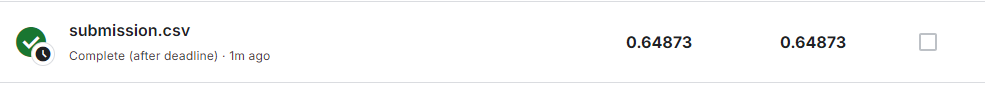